In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Train Base Models and Evaluate

In this notebook, we will train several baseline models to establish a performance benchmark for our depression classification task. We will evaluate these models using appropriate metrics and select the best-performing ones for further tuning and validation.

In [2]:
import pandas as pd
import numpy as np

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 0)          # auto-detect wide console
pd.set_option("display.max_colwidth", None)

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Learner/Competitions/mental_health_clas_prob/data/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

## Data Preparation

In [4]:
df.head(20)

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0
5,5,Vani,Female,59.0,Ahmedabad,Working Professional,Finanancial Analyst,NaN,2.0,NaN,NaN,5.0,5-6 hours,Healthy,MCA,No,7.0,5.0,No,0
6,6,Ritvik,Male,47.0,Thane,Working Professional,Chemist,NaN,5.0,NaN,NaN,2.0,7-8 hours,Moderate,MD,No,6.0,2.0,No,0
7,7,Rajveer,Male,38.0,Nashik,Working Professional,Teacher,NaN,3.0,NaN,NaN,4.0,7-8 hours,Unhealthy,B.Pharm,No,10.0,3.0,Yes,0
8,8,Aishwarya,Female,24.0,Bangalore,Student,NaN,2.0,NaN,5.90,5.0,NaN,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
9,9,Simran,Female,42.0,Patna,Working Professional,Electrician,NaN,4.0,NaN,NaN,1.0,5-6 hours,Healthy,ME,Yes,7.0,2.0,Yes,0


### Fill null values

In [5]:
df.isnull().sum()

,0
id,0
Name,0
Gender,0
Age,0
City,0
Working Professional or Student,0
Profession,36630
Academic Pressure,112803
Work Pressure,27918
CGPA,112802


In [6]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def stratified_fill_likert(df, col, by, clip=(1,5)):
    out = df.copy()
    # groupwise median (works well for ordinal Likert)
    grp_med = out.groupby(by)[col].transform('median')
    # fallback: global median if a group is all-missing
    global_med = out[col].median()
    fill_vals = grp_med.fillna(global_med)
    # fill only missing
    mask = out[col].isna()
    out.loc[mask, col] = fill_vals[mask]
    # clip and round to integers 1..5
    lo, hi = clip
    out[col] = np.rint(np.clip(out[col], lo, hi)).astype(int)
    # add indicator
    out[f'{col}_was_imputed'] = False
    out.loc[mask, f'{col}_was_imputed'] = True
    return out


def impute_with_xgb(
    df, target, feature_cols, categorical_cols=(), clip=None, round_to_int=False,
    random_state=42
):
    df = df.copy()

    # 0) Masks
    mask_known = df[target].notna()
    mask_missing = ~mask_known

    # 1) Build design matrix ONCE (numeric + OHE categoricals)
    X = df[feature_cols].copy()

    if categorical_cols:
        # If your sklearn is <1.2 use sparse=False instead of sparse_output=False
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        enc = ohe.fit_transform(df[categorical_cols])
        X = X.drop(columns=list(categorical_cols))
        X = np.hstack([X.to_numpy(dtype=np.float32), enc])
    else:
        X = X.to_numpy(dtype=np.float32)

    y = df[target].to_numpy()

    # 2) Validation on known rows only
    X_known = X[mask_known]
    y_known = y[mask_known]

    # Edge case: if not enough known rows, skip modeling safely
    if len(y_known) < 5:
        print(f"[{target}] Not enough known rows ({len(y_known)}) to validate. Skipping.")
        return df

    X_tr, X_val, y_tr, y_val = train_test_split(
        X_known, y_known, test_size=0.2, random_state=random_state
    )

    model = XGBRegressor(
        n_estimators=400,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        tree_method='auto',
        random_state=random_state
    )

    model.fit(X_tr, y_tr)

    # Validation metric (known → known)
    val_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, val_pred)

    # 3) If there are missing rows, predict them
    n_missing = int(mask_missing.sum())
    if n_missing > 0:
        X_missing = X[mask_missing]
        y_hat = model.predict(X_missing)

        if clip is not None:
            lo, hi = clip
            y_hat = np.clip(y_hat, lo, hi)

        if round_to_int:
            y_hat = np.rint(y_hat)

        df.loc[mask_missing, target] = y_hat

    # 4) Print a compact health report (always prints)
    before_missing = n_missing
    after_missing = int(df[target].isna().sum())
    print(
        f"[{target}] RMSE={rmse:.4f} | missing before={before_missing} "
        f"| missing after={after_missing}"
    )

    return df


def handle_nulls(df):
    df_out = df.copy()

    # --- Student-only numeric fields ---
    student_mask = df_out['Working Professional or Student'] == 'Student'

    # Academic Pressure
    df_out.loc[~student_mask, 'Academic Pressure'] = 0
    med_ap = df_out.loc[student_mask, 'Academic Pressure'].median()
    if pd.isna(med_ap):
        med_ap = 0
    df_out.loc[student_mask & df_out['Academic Pressure'].isna(), 'Academic Pressure'] = med_ap

    # CGPA
    df_out.loc[~student_mask, 'CGPA'] = 0
    med_cg = df_out.loc[student_mask, 'CGPA'].median()
    if pd.isna(med_cg):
        med_cg = 0
    df_out.loc[student_mask & df_out['CGPA'].isna(), 'CGPA'] = med_cg

    # Study Satisfaction
    df_out.loc[~student_mask, 'Study Satisfaction'] = 0
    med_ss = df_out.loc[student_mask, 'Study Satisfaction'].median()
    if pd.isna(med_ss):
        med_ss = 0
    df_out.loc[student_mask & df_out['Study Satisfaction'].isna(), 'Study Satisfaction'] = med_ss

    # --- GPU model-based imputations ---
    # 1) Financial Stress
    df_out = impute_with_xgb(
        df_out,
        target="Financial Stress",
        feature_cols=["Age", "Work/Study Hours", "Job Satisfaction", "Profession"],
        categorical_cols=['Profession'],
        clip=(0, 10)  # adjust if your scale differs
    )

    # 2) Job Satisfaction (Likert 1–5 → clip & round)
    df_test = df_out.copy()
    df_test['Profession'] = df_out['Profession'].fillna('Unknown')
    df_test['StudentFlag'] = (df_out['Working Professional or Student'] == 'Student').astype(int)
    df_test['AgeBand'] = pd.cut(df_out['Age'], bins=[0,25,35,45,55,120], labels=['<=25','26-35','36-45','46-55','56+'])
    df_test['HoursBand'] = pd.cut(df_out['Work/Study Hours'], bins=[-1,2,5,8,12,1e9], labels=['<=2','3-5','6-8','9-12','>12'])

    df_out = stratified_fill_likert(df_test, 'Job Satisfaction', by=['Profession','StudentFlag','AgeBand','HoursBand'])

    # 3) Work Pressure (Likert 1–5) — include Profession signal
    df_out = impute_with_xgb(
        df_out,
        target="Work Pressure",
        feature_cols=["Age", "Work/Study Hours", "Job Satisfaction", "Financial Stress", "Profession"],
        categorical_cols=['Profession'],
        clip=(1, 5),
        round_to_int=True
    )

    columns_to_drop = ['AgeBand', 'HoursBand']
    df_out = df_out.drop(columns=columns_to_drop)
    return df_out

df = handle_nulls(df)

[Financial Stress] RMSE=1.9944 | missing before=4 | missing after=0
[Work Pressure] RMSE=1.9520 | missing before=27918 | missing after=0


### Fix data values

In [7]:
# Professions
professions = [
    "Teacher",
    "Content Writer",
    "Architect",
    "Consultant",
    "HR Manager",
    "Pharmacist",
    "Doctor",
    "Business Analyst",
    "Entrepreneur",
    "Chemist",
    "Chef",
    "Educational Consultant",
    "Data Scientist",
    "Researcher",
    "Lawyer",
    "Customer Support",
    "Marketing Manager",
    "Pilot",
    "Travel Consultant",
    "Plumber",
    "Sales Executive",
    "Manager",
    "Judge",
    "Electrician",
    "Financial Analyst",
    "Software Engineer",
    "Civil Engineer",
    "UX/UI Designer",
    "Digital Marketer",
    "Accountant",
    "Mechanical Engineer",
    "Graphic Designer",
    "Research Analyst",
    "Investment Banker",
    "Student",
    "Academic",
    "Unemployed",
    "Family Consultant"
]

# Cities
valid_cities = [
    "Kalyan","Patna","Vasai-Virar","Kolkata","Ahmedabad","Meerut","Ludhiana","Pune","Rajkot",
    "Visakhapatnam","Srinagar","Mumbai","Indore","Agra","Surat","Varanasi","Vadodara","Hyderabad",
    "Kanpur","Jaipur","Thane","Lucknow","Nagpur","Bangalore","Chennai","Ghaziabad","Delhi","Bhopal",
    "Faridabad","Nashik","Morena","Gurgaon"
]

# Degrees
valid_degrees = [
    "Class 11",
    "Class 12",
    "BA",
    "MA",
    "B.Com",
    "M.Com",
    "BSc",
    "MSc",
    "B.Ed",
    "M.Ed",
    "BBA",
    "MBA",
    "BCA",
    "MCA",
    "B.Tech",
    "M.Tech",
    "BE",
    "ME",
    "B.Arch",
    "M.Arch",
    "BHM",
    "MHM",
    "B.Pharm",
    "M.Pharm",
    "MBBS",
    "MD",
    "PhD",
    "LLB",
    "LLM",
    "MPA",
    "BPA",
    "ACA"
]


In [8]:
def fix_data(df):
    df_out = df.copy()
    cols = ['City', 'Profession', 'Dietary Habits', 'Sleep Duration', 'Degree']
    for c in cols:
        if c in df_out.columns:
            df_out[c] = df_out[c].astype('string')

    # Fix city name
    df_out['City'] = df_out['City'].where(df_out['City'].isin(valid_cities), 'unknown')

    # Fix professions
    df_out['Profession'] = df_out['Profession'].where(df_out['Profession'].isin(professions), 'unknown')

    # Fix dietary habits
    mapping = {
    "More Healthy": "Healthy",
    "Less Healthy": "Moderate",
    "Less than Healthy": "Moderate",
    "No Healthy": "Unhealthy"
    }
    df_out['Dietary Habits'] = df_out['Dietary Habits'].replace(mapping)

    valid_diet = ["Moderate", "Unhealthy", "Healthy"]
    df_out['Dietary Habits'] = df_out['Dietary Habits'].where(df_out['Dietary Habits'].isin(valid_diet), 'unknown')

    # Fix sleep
    valid_sleep = ['Less than 5 hours', '7-8 hours', 'More than 8 hours',
                '5-6 hours']

    def normalize_sleep_duration(val: str):
        if pd.isna(val):
            return np.nan

        v = str(val).strip()
        if v in valid_sleep:
            return v

        v = v.lower()

        # Bucket 1: Less than 5 hours
        if any(
            x in v for x in [
                '3-4', '2-3', '1-2'
            ]
        ):
            return 'Less than 5 hours'

        # Bucket 2: More than 8 hours
        if any (
            x in v for x in [
                '9-11', '10-11'
            ]
        ):
            return 'More than 8 hours'
        return np.nan

    df_out['Sleep Duration'] = df_out['Sleep Duration'].apply(normalize_sleep_duration)
    # Sleep Duration fill nulls (make a new category)
    df_out['Sleep Duration'] = df_out['Sleep Duration'].astype('object').fillna('Unknown').astype('category')

    # Fix degrees
    df_out['Degree'] = df_out['Degree'].where(df_out['Degree'].isin(valid_degrees), 'unknown')

    # Fix financial stress
    df_out['Financial Stress'] = df_out['Financial Stress'].round().clip(1, 5).astype(int)


    return df_out

df = fix_data(df)

### Fix Data Types

In [9]:
numeric_cols = ['Age',
                 'CGPA']
categorical_cols = ['Gender', 'City', 'Working Professional or Student',
                     'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree'
                     ,'Study Satisfaction', 'Academic Pressure', 'Work Pressure', 'Job Satisfaction', 'Financial Stress'
                     ,'Work/Study Hours']

In [10]:
# Fix data types
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df[categorical_cols] = df[categorical_cols].astype('category')

In [11]:
yn_map = {
    'yes': 1,
    'no': 0,
}

def map_yes_no(series):
    s = series.astype(str).str.strip().str.lower().map(yn_map)
    return s.astype(int)  # pandas nullable boolean

df['Have you ever had suicidal thoughts ?'] = map_yes_no(df['Have you ever had suicidal thoughts ?'])
df['Family History of Mental Illness']     = map_yes_no(df['Family History of Mental Illness'])

### Handle Outliers

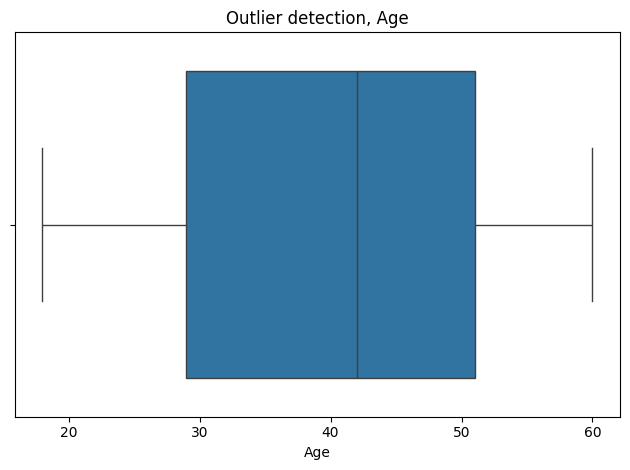

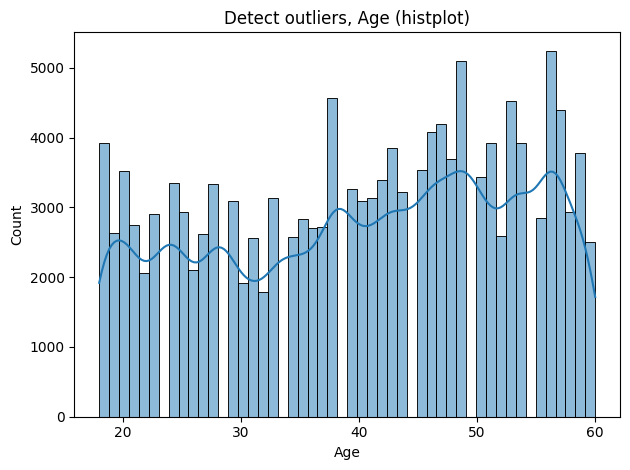

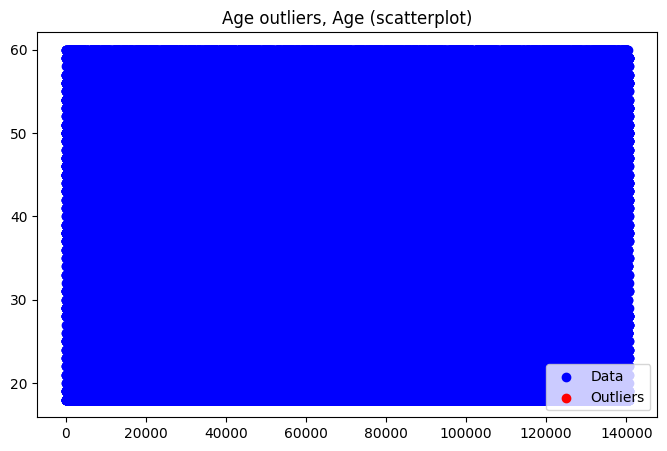

In [12]:
target = 'Age'
# Age outliers
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x=df[target])
plt.title(f'Outlier detection, {target}')
plt.tight_layout()
plt.show()

sns.histplot(df[target], kde=True)
plt.title(f'Detect outliers, {target} (histplot)')
plt.tight_layout()
plt.show()

z = (df[target] - df[target].mean()) / df[target].std()
outliers = df[np.abs(z) > 3]

plt.figure(figsize=(8,5))
plt.title(f'{target} outliers, Age (scatterplot)')
plt.scatter(df.index, df[target], color='blue', label='Data')
plt.scatter(outliers.index, outliers[target], color='red', label='Outliers')
plt.legend()
plt.show()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 22 columns):
 #   Column                                 Non-Null Count   Dtype   
---  ------                                 --------------   -----   
 0   id                                     140700 non-null  int64   
 1   Name                                   140700 non-null  object  
 2   Gender                                 140700 non-null  category
 3   Age                                    140700 non-null  float64 
 4   City                                   140700 non-null  category
 5   Working Professional or Student        140700 non-null  category
 6   Profession                             140700 non-null  category
 7   Academic Pressure                      140700 non-null  category
 8   Work Pressure                          140700 non-null  category
 9   CGPA                                   140700 non-null  float64 
 10  Study Satisfaction                     14070

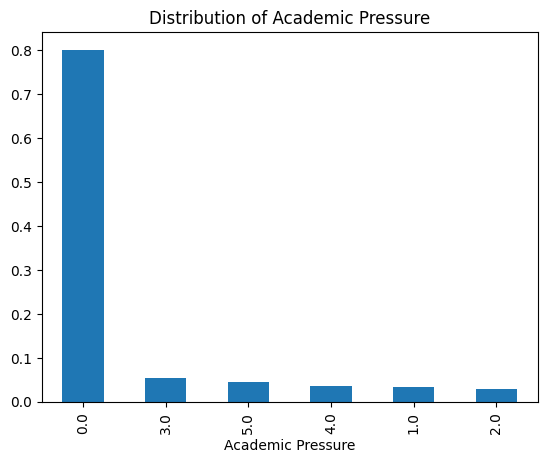

In [14]:
target = 'Academic Pressure'
# Academic Pressure outliers
df[target].value_counts(normalize=True).plot(kind='bar')
plt.title(f"Distribution of {target}")
plt.show()

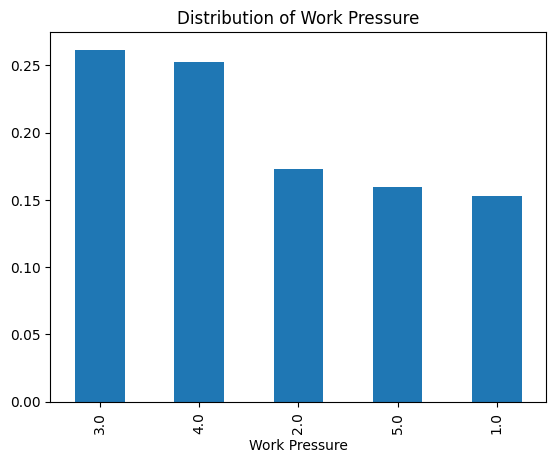

In [15]:
target = 'Work Pressure'
# Academic Pressure outliers
df[target].value_counts(normalize=True).plot(kind='bar')
plt.title(f"Distribution of {target}")
plt.show()

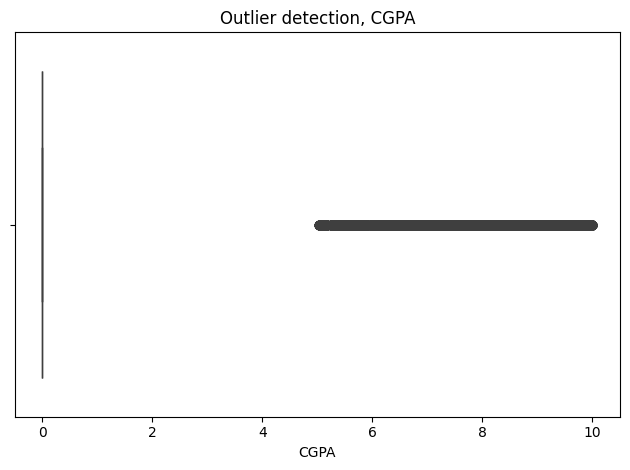

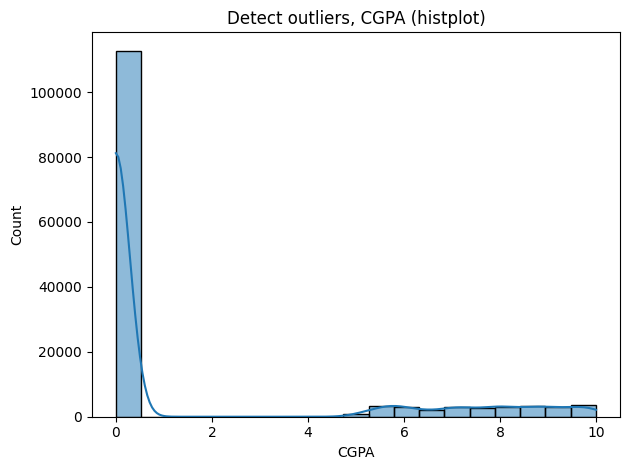

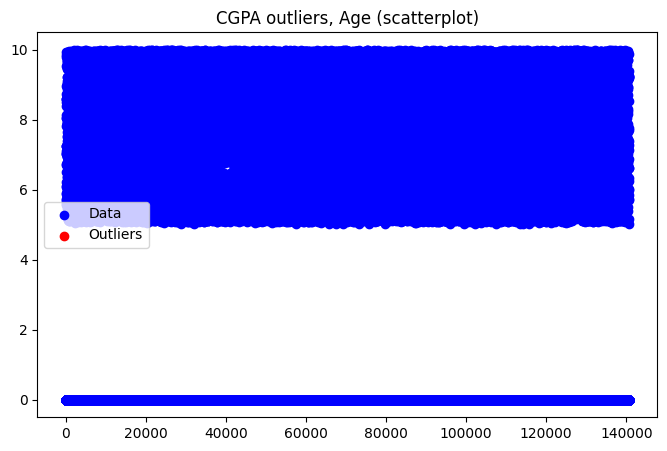

In [16]:
target = 'CGPA'
# Age outliers
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x=df[target])
plt.title(f'Outlier detection, {target}')
plt.tight_layout()
plt.show()

sns.histplot(df[target], kde=True)
plt.title(f'Detect outliers, {target} (histplot)')
plt.tight_layout()
plt.show()

z = (df[target] - df[target].mean()) / df[target].std()
outliers = df[np.abs(z) > 3]

plt.figure(figsize=(8,5))
plt.title(f'{target} outliers, Age (scatterplot)')
plt.scatter(df.index, df[target], color='blue', label='Data')
plt.scatter(outliers.index, outliers[target], color='red', label='Outliers')
plt.legend()
plt.show()

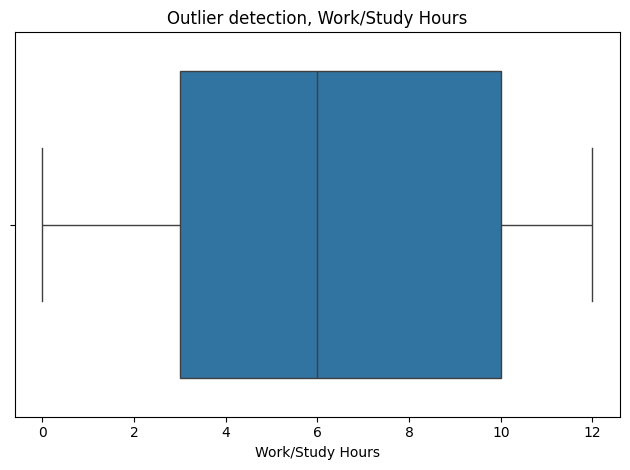

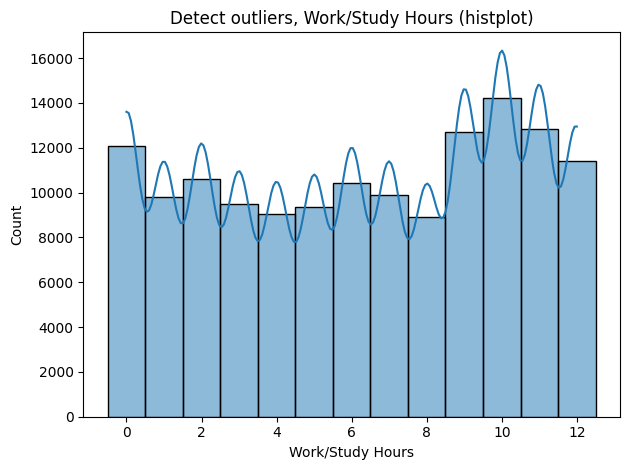

In [17]:
target = 'Work/Study Hours'
# Age outliers
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x=df[target])
plt.title(f'Outlier detection, {target}')
plt.tight_layout()
plt.show()

sns.histplot(df[target], kde=True)
plt.title(f'Detect outliers, {target} (histplot)')
plt.tight_layout()
plt.show()

## Preprocessing Pipeline

In [18]:
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# numeric
numeric_cols = ['CGPA', 'StudentFlag']


categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
]).set_output(transform='pandas')

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
]).set_output(transform='pandas')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer,
            selector(dtype_include=['category', 'object', 'string'])),
        ('num', numerical_transformer, numeric_cols),
    ],
    remainder='drop'
).set_output(transform='pandas')

### Feature Engineering (basic)

In [19]:
from sklearn.preprocessing import FunctionTransformer

def basic_fe_fn(df: pd.DataFrame) -> pd.DataFrame:
    df_out = df.copy()

    # Age bins -> categorical
    age_bins   = [17, 25, 35, 45, 55, 60]
    age_labels = ['18-25', '26-35', '36-45', '46-55', '56-60']
    if 'Age' in df_out.columns:
        df_out['Age_Bin'] = pd.cut(
            df_out['Age'], bins=age_bins, labels=age_labels, right=True, include_lowest=True
        )
        df_out = df_out.drop(columns=['Age'])

    # Study/Work hours bins -> categorical
    hrs_bins   = [-0.5, 2, 5, 8, 12]
    hrs_labels = ['Less than 2', '3-5', '6-8', '9-12']
    if 'Work/Study Hours' in df_out.columns:
        df_out['Study_Hours_Bin'] = pd.cut(
            df_out['Work/Study Hours'], bins=hrs_bins, labels=hrs_labels, right=True, include_lowest=True
        )

    # Ensure int-coded categoricals are treated as categoricals for OHE
    int_cats = ['Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
    for c in int_cats:
        if c in df_out.columns:
            df_out[c] = df_out[c].astype('category')

    return df_out

basic_fe = FunctionTransformer(basic_fe_fn, validate=False)

### Complete pipeline

In [20]:
columns_to_drop = ['id', 'Depression', 'Name']

def drop_unused(df: pd.DataFrame) -> pd.DataFrame:
    cols = [c for c in columns_to_drop if c in df.columns]
    return df.drop(columns=cols)

dropper = FunctionTransformer(drop_unused, validate=False)

In [21]:
from sklearn.pipeline import Pipeline

pipeline_basic_prep = Pipeline(steps=[
    ('basic_fe', basic_fe),     # adds Age_Bin & Study_Hours_Bin, drops Age
    ('dropper', dropper),       # drops id, Name, Depression from X
    ('preprocessing', preprocessor)
]).set_output(transform='pandas')

In [22]:
X_preprocessed = pipeline_basic_prep.fit_transform(df)
print("Preprocessed width:", X_preprocessed.shape[1])

Preprocessed width: 173


In [23]:
# Expected one-hot width (after FE):
X_fe = basic_fe_fn(df.copy()).drop(columns=columns_to_drop, errors='ignore')
expected_ohe = sum(X_fe[c].nunique(dropna=True) for c in categorical_cols if c in X_fe)
print("Expected OHE width:", expected_ohe, "+", len(numeric_cols), "numeric")

Xt = pipeline_basic_prep.fit_transform(df)
print("Actual width:", Xt.shape[1])

Expected OHE width: 158 + 2 numeric
Actual width: 173


In [24]:
import pandas as pd

# Build the exact frame OHE sees (post-FE, post-drop)
X_fe = basic_fe_fn(df.copy()).drop(columns=columns_to_drop, errors='ignore')

Xt = pipeline_basic_prep.fit_transform(df)

ct  = pipeline_basic_prep.named_steps['preprocessing']
ohe = ct.named_transformers_['cat'].named_steps['onehot']
ohe_inputs = list(ohe.feature_names_in_)  # columns that actually went into OHE
ohe_output_features = ohe.get_feature_names_out(ohe_inputs) # get all output feature names once

def expected_ohe_width_like_sklearn(s: pd.Series) -> int:
    # Sklearn uses dtype.categories for Categorical; otherwise unique values (including NaN if not filled)
    if pd.api.types.is_categorical_dtype(s):
        return len(s.cat.categories)
    else:
        # mirror OHE's default: include NaN as a separate level if present
        return s.nunique(dropna=False)

calc = []
for c in ohe_inputs:
    s = X_fe[c]
    exp = expected_ohe_width_like_sklearn(s)
    # actual columns emitted for this feature:
    actual = sum(1 for name in ohe_output_features if name.startswith(f"cat__{c}_")) # Count features starting with 'cat__c_'
    has_nan = s.isna().any()
    cat_len = len(s.cat.categories) if pd.api.types.is_categorical_dtype(s) else None
    calc.append((c, str(s.dtype), has_nan, s.nunique(dropna=True), cat_len, exp, actual))

audit = pd.DataFrame(calc, columns=["feature","dtype","has_nan","nunique(dropna=True)","cat_len(if Categorical)","expected_like_sklearn","actual_emitted"])
display(audit.sort_values("actual_emitted", ascending=False).head(20))

print("Expected total (like sklearn):", sum(expected_ohe_width_like_sklearn(X_fe[c]) for c in ohe_inputs), "+", len(ct.transformers_[1][2]), "numeric")
print("Actual total:", Xt.shape[1])

,feature,dtype,has_nan,nunique(dropna=True),cat_len(if Categorical),expected_like_sklearn,actual_emitted
0,Gender,category,False,2,2,2,0
1,City,category,False,33,33,33,0
2,Working Professional or Student,category,False,2,2,2,0
3,Profession,category,False,39,39,39,0
4,Academic Pressure,category,False,6,6,6,0
5,Work Pressure,category,False,5,5,5,0
6,Study Satisfaction,category,False,6,6,6,0
7,Job Satisfaction,category,False,5,5,5,0
8,Sleep Duration,category,False,5,5,5,0
9,Dietary Habits,category,False,4,4,4,0


Expected total (like sklearn): 171 + 2 numeric
Actual total: 173


## Model training pipeline

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Sample the dataset for training
df_train = df.sample(n=10_000, random_state=42)
df_train.shape

# Train test split the data
y = df_train['Depression'].astype(int)
X = df_train.copy()

# Limit the dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


models = {
    "LogReg" : LogisticRegression(max_iter=2000, class_weight='balanced'),
    "RF" : RandomForestClassifier(n_estimators=300, n_jobs=-1, class_weight='balanced', random_state=42),
    "XGB" : XGBClassifier(eval_metric='auc', use_label_encoder=False, n_jobs=-1, random_state=42),
    "LGBM" : LGBMClassifier(class_weight='balanced', n_jobs=-1, random_state=42)
}

param_grids = {
    "LogReg" : {
        'clf__C' : [0.1, 1, 10],
        'clf__penalty' : ['l2'],
        'clf__solver' : ['lbfgs']
    },
    "RF" : {
        'clf__n_estimators' : [200, 500],
        'clf__max_depth' : [None, 20, 50],
        'clf__min_samples_split' : [2, 10]
    },
    "XGB" : {
        'clf__n_estimators' : [300, 500],
        'clf__learning_rate' : [0.01, 0.05],
        'clf__max_depth' : [4, 6, 8],
        'clf__subsample' : [0.8, 1.0],
        'clf__colsample_bytree' : [0.8, 1.0]
    },
    'LGBM' : {
        'clf__n_estimators' : [300, 500],
        'clf__learning_rate' : [0.01, 0.05],
        'clf__max_depth' : [-1, 20, 50],
        'clf__subsample' : [0.8, 1.0],
        'clf__colsample_bytree' : [0.8, 1.0]
    }
}

# Initiate common cv strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
best_models = {}

for name, model in models.items():
  print(f"GridSearch CV for {name}")

  # Full pipeline
  pipe_train_base = Pipeline(
      steps = [
          ('prep', pipeline_basic_prep),
          ('clf', model)
      ]
  ).set_output(transform='pandas')

  gcv = GridSearchCV(
      estimator=pipe_train_base,
      param_grid=param_grids[name],
      scoring='roc_auc',
      cv=cv,
      n_jobs=-1,
      verbose=1
  )

  gcv.fit(X_train, y_train)

  best_model = gcv.best_estimator_
  best_models[name] = best_model

  results[name] = {
      'best_score' : gcv.best_score_,
      'best_params' : gcv.best_params_
  }

for name, res in results.items():
  print(f"{name} : {res['best_score']:.4f} with {res['best_params']}")

GridSearch CV for LogReg
Fitting 5 folds for each of 3 candidates, totalling 15 fits
GridSearch CV for RF
Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearch CV for XGB
Fitting 5 folds for each of 48 candidates, totalling 240 fits
GridSearch CV for LGBM
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1475, number of negative: 6525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 158
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LogReg : 0.9738 with {'clf__C':

## Evaluation (base models)


In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

evals = {}

for name, model in best_models.items():
  print(f"{name} Evaluation on test set")

  # predictions
  y_pred = model.predict(X_test)
  y_proba = model.predict_proba(X_test)[:, 1]

  # metrics
  acc = accuracy_score(y_test, y_pred)
  roc = roc_auc_score(y_test, y_proba)
  cm = confusion_matrix(y_test, y_pred)


  print(f"Accuracy: {round(acc, 4)}")
  print(f"ROC AUC: {round(roc, 4)}")
  print(classification_report(y_test, y_pred, digits=3, zero_division=0))

  # Save for plotting later
  evals[name] = {
      "y_pred" : y_pred,
      "y_proba" : y_proba,
      "acc" : acc,
      "roc" : roc,
      "cm" : cm
  }

LogReg Evaluation on test set
Accuracy: 0.918
ROC AUC: 0.9711
              precision    recall  f1-score   support

           0      0.978     0.920     0.948      1631
           1      0.719     0.911     0.804       369

    accuracy                          0.918      2000
   macro avg      0.849     0.915     0.876      2000
weighted avg      0.931     0.918     0.922      2000

RF Evaluation on test set
Accuracy: 0.9195
ROC AUC: 0.968
              precision    recall  f1-score   support

           0      0.936     0.967     0.951      1631
           1      0.829     0.710     0.765       369

    accuracy                          0.919      2000
   macro avg      0.883     0.838     0.858      2000
weighted avg      0.917     0.919     0.917      2000

XGB Evaluation on test set
Accuracy: 0.9245
ROC AUC: 0.9701
              precision    recall  f1-score   support

           0      0.946     0.963     0.954      1631
           1      0.821     0.756     0.787       369

  

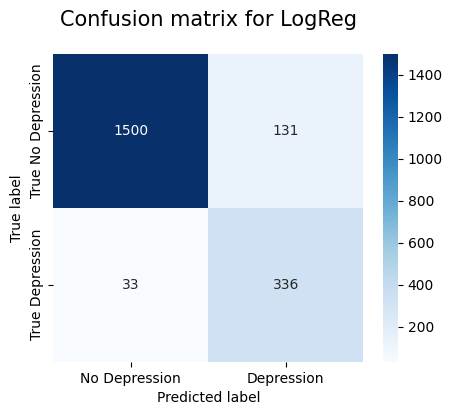

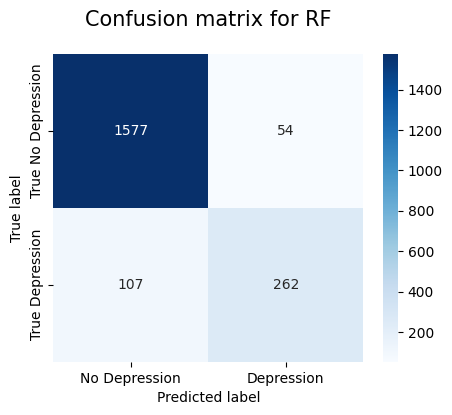

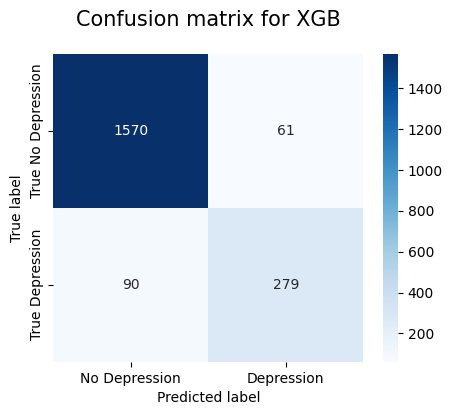

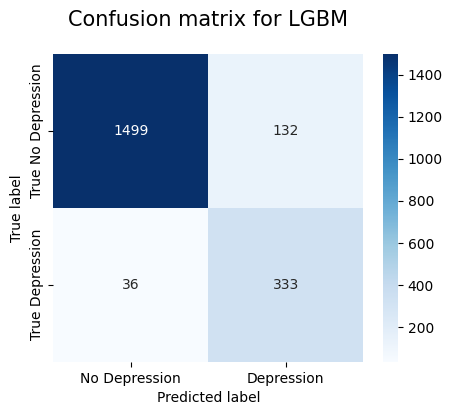

In [27]:
# plot the confusion matrices

for name, ev in evals.items():
  plt.figure(figsize=(5,4))
  sns.heatmap(
      ev['cm'], annot=True, fmt='d', cmap='Blues',
      xticklabels = ['No Depression', 'Depression'],
      yticklabels = ['True No Depression', 'True Depression']
  )
  plt.title(f'Confusion matrix for {name}', fontsize=15, pad=20)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

## Feature Importance

In [32]:
# Get final feature names coming out of prep pipeline
# pick any fitted pipeline all works the same
prep = next(iter(best_models.values())).named_steps['prep']
feature_names = pipe_train_base[:-1].fit_transform(X_train).columns
len(feature_names), feature_names[:10]

(165,
 Index(['cat__Gender_Female', 'cat__Gender_Male', 'cat__City_Agra',
        'cat__City_Ahmedabad', 'cat__City_Bangalore', 'cat__City_Bhopal',
        'cat__City_Chennai', 'cat__City_Delhi', 'cat__City_Faridabad',
        'cat__City_Ghaziabad'],
       dtype='object'))

### Feature Importances for Logisitic Regression Model

In [33]:
clf = best_models['LogReg'].named_steps['clf']

# get the coefficients (one per feature) and flatten the 2D array
coefs = clf.coef_.ravel()

# make a dataframe of features + coefficients
# negative coefficients = result -> "0" (not depressed)
# positive coefficients = result -> "1" (depressed)
logreg_imp = (
    pd.DataFrame({
        "feature" : feature_names,
        "coef" : coefs,
        # to sort features by the strength we use absolute value. (no negatives or positives just higher and lower)
        "importance" : np.abs(coefs)
    }).sort_values("importance", ascending=False, ignore_index=True)
)

logreg_imp.head(20)

,feature,coef,importance
0,cat__Age_Bin_18-25,2.252328,2.252328
1,cat__Age_Bin_56-60,-1.732198,1.732198
2,cat__Age_Bin_26-35,1.516506,1.516506
3,cat__Age_Bin_46-55,-1.514122,1.514122
4,cat__Academic Pressure_1.0,-1.166783,1.166783
5,cat__Work Pressure_5.0,1.137630,1.137630
6,cat__Have you ever had suicidal thoughts ?_0,-1.134717,1.134717
7,cat__Have you ever had suicidal thoughts ?_1,1.131016,1.131016
8,cat__Academic Pressure_5.0,1.045593,1.045593
9,cat__Job Satisfaction_1,1.042042,1.042042


### Feature Importances for Tree models.

In [49]:
clf = best_models['RF'].named_steps['clf']
rf_imp = (
    pd.DataFrame(
        {
            "feature" : feature_names,
            "importance" : clf.feature_importances_
        }
    ).sort_values("importance", ascending=False, ignore_index=True)
)

rf_imp.head(20)

,feature,importance
0,cat__Age_Bin_18-25,0.082607
1,cat__Profession_unknown,0.059800
2,cat__Have you ever had suicidal thoughts ?_0,0.054906
3,num__CGPA,0.050571
4,cat__Have you ever had suicidal thoughts ?_1,0.049670
5,cat__Study Satisfaction_0.0,0.037448
6,cat__Working Professional or Student_Student,0.035034
7,cat__Academic Pressure_0.0,0.034839
8,cat__Age_Bin_46-55,0.032665
9,cat__Working Professional or Student_Working Professional,0.029634


In [50]:
clf = best_models['XGB'].named_steps['clf']
booster = clf.get_booster()

xgb_imp = (
    pd.DataFrame.from_dict(
        booster.get_score(importance_type="gain"),
        orient="index",
        columns=["importance_gain"]
    )
    .sort_values("importance_gain", ascending=False)
    .reset_index()
    .rename(columns={"index": "feature"})
)

xgb_imp.head(20)

,feature,importance_gain
0,cat__Profession_unknown,437.067627
1,cat__Working Professional or Student_Student,73.275002
2,cat__Age_Bin_18-25,45.102287
3,cat__Have you ever had suicidal thoughts ?_0,44.061569
4,cat__Age_Bin_26-35,42.724106
5,cat__Working Professional or Student_Working Professional,42.634045
6,cat__Have you ever had suicidal thoughts ?_1,35.787010
7,cat__Age_Bin_46-55,13.154125
8,cat__Financial Stress_5,12.629671
9,cat__Academic Pressure_1.0,12.332961


In [45]:
clf = best_models['LGBM'].named_steps['clf']

lgbm_imp = (
    pd.DataFrame(
        {
            "feature" : feature_names,
            "importance_split": clf.booster_.feature_importance(importance_type="split"),
            "importance_gain": clf.booster_.feature_importance(importance_type="gain")
        }
    ).sort_values("importance_gain", ascending=False, ignore_index=True)
)

lgbm_imp.head(20)

,feature,importance_split,importance_gain
0,cat__Profession_unknown,242,178094.605336
1,cat__Have you ever had suicidal thoughts ?_0,966,52952.740427
2,cat__Age_Bin_18-25,726,44934.183341
3,cat__Age_Bin_26-35,455,38296.717401
4,cat__Financial Stress_5,585,11044.396895
5,cat__Work Pressure_5.0,558,7482.182734
6,cat__Job Satisfaction_1,440,6391.732251
7,num__CGPA,593,5577.589951
8,cat__Financial Stress_1,487,5281.420496
9,cat__Dietary Habits_Unhealthy,448,5275.032973
